In [60]:
	
from statsbombpy import sb
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter

In [61]:
events = sb.competition_events(
    country="Germany",
    division= "1. Bundesliga",
    season="2023/2024",
    gender="male"
)

/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarni

In [ ]:
#make a list to hold a df of the events of a match
df_lst = []

for id in events.match_id.unique():
    #find one match for one team
    match_subset = events.loc[events['match_id'] == id]

    starting_11 = match_subset.loc[match_subset['type'] == 'Starting XI'].loc[match_subset['team'] == 'Bayer Leverkusen', 'tactics'].to_dict()[0]
    position_dict = {}
    
    for member in starting_11['lineup']:
        print(member)
        player_id = int(member['player']['id'])
        position_name = member['position']['name']
        position_dict[player_id] = position_name

    match_subset = match_subset.loc[match_subset['possession_team'] == 'Bayer Leverkusen']

    #include only passes and shots
    match_subset = match_subset.loc[(match_subset['type'] == 'Shot') | (match_subset['type'] =='Pass')| (match_subset['type'] =='Substitution')]

    #sort the values like when we did the passing sequences
    match_subset = match_subset.sort_values(['period','timestamp'], ascending=[True, True])

    match_subset['pass_recipient_position'] = None

    for index, row in match_subset.iterrows():
        if row['type'] == 'Substitution':
            position_dict[row['substitution_replacement_id']] = row['position']
    
        elif pd.notna(row['pass_recipient_id']):
            match_subset.at[index, 'pass_recipient_position'] = position_dict[int(row['pass_recipient_id'])]
    
            if row['position'] != position_dict[row['player_id']]:
                position_dict[row['player_id']] = row['position']
            

    match_subset.loc[match_subset['type'] =='Pass'].loc[match_subset['pass_recipient_id'].notna(),'pass_recipient_position'] = match_subset['position'].shift(-1)

    #de næste to linjer kan eventuelt kommenteres ud, og så kan vi bare fjerne na i stedet, hvis vi ikke vil have de ekstra nodes, jeg foreslår :D

    #if a pass does not have a recipient fill the field with the outcome. This allows us to create "out" or "incomplete" nodes if we wish
    match_subset.loc[match_subset['type'] =='Pass', 'pass_recipient_position'] = match_subset.apply(lambda x: np.where(pd.isna(x['pass_recipient_position']), x['pass_outcome'], x['pass_recipient_position']), axis=1)

    #add shot as a pass recipient as well
    match_subset.loc[match_subset['type'] =='Shot', 'pass_recipient_position'] = match_subset.apply(lambda x: np.where(pd.isna(x['pass_recipient_position']), x['shot_outcome'], x['pass_recipient_position']), axis=1)


    df_lst.append(match_subset)   

{'player': {'id': 8667, 'name': 'Lukáš Hrádecký'}, 'position': {'id': 1, 'name': 'Goalkeeper'}, 'jersey_number': 1}
{'player': {'id': 27133, 'name': 'Odilon Kossonou'}, 'position': {'id': 3, 'name': 'Right Center Back'}, 'jersey_number': 6}
{'player': {'id': 8221, 'name': 'Jonathan Tah'}, 'position': {'id': 4, 'name': 'Center Back'}, 'jersey_number': 4}
{'player': {'id': 30606, 'name': 'Edmond Fayçal Tapsoba'}, 'position': {'id': 5, 'name': 'Left Center Back'}, 'jersey_number': 12}
{'player': {'id': 41411, 'name': 'Nathan Tella'}, 'position': {'id': 7, 'name': 'Right Wing Back'}, 'jersey_number': 19}
{'player': {'id': 38004, 'name': 'Piero Martín Hincapié Reyna'}, 'position': {'id': 8, 'name': 'Left Wing Back'}, 'jersey_number': 3}
{'player': {'id': 3500, 'name': 'Granit Xhaka'}, 'position': {'id': 9, 'name': 'Right Defensive Midfield'}, 'jersey_number': 34}
{'player': {'id': 9195, 'name': 'Robert Andrich'}, 'position': {'id': 11, 'name': 'Left Defensive Midfield'}, 'jersey_number': 8}

/var/folders/_3/q0p4rhwn0r31w83n5ds1htx40000gn/T/ipykernel_15213/1293551056.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_subset['pass_recipient_position'] = None


KeyError: 12299

In [ ]:
dict = {'formation': 3421, 'lineup': [{'player': {'id': 8667, 'name': 'Lukáš Hrádecký'}, 'position': {'id': 1, 'name': 'Goalkeeper'}, 'jersey_number': 1}, {'player': {'id': 27133, 'name': 'Odilon Kossonou'}, 'position': {'id': 3, 'name': 'Right Center Back'}, 'jersey_number': 6}, {'player': {'id': 8221, 'name': 'Jonathan Tah'}, 'position': {'id': 4, 'name': 'Center Back'}, 'jersey_number': 4}, {'player': {'id': 30606, 'name': 'Edmond Fayçal Tapsoba'}, 'position': {'id': 5, 'name': 'Left Center Back'}, 'jersey_number': 12}, {'player': {'id': 41411, 'name': 'Nathan Tella'}, 'position': {'id': 7, 'name': 'Right Wing Back'}, 'jersey_number': 19}, {'player': {'id': 38004, 'name': 'Piero Martín Hincapié Reyna'}, 'position': {'id': 8, 'name': 'Left Wing Back'}, 'jersey_number': 3}, {'player': {'id': 3500, 'name': 'Granit Xhaka'}, 'position': {'id': 9, 'name': 'Right Defensive Midfield'}, 'jersey_number': 34}, {'player': {'id': 9195, 'name': 'Robert Andrich'}, 'position': {'id': 11, 'name': 'Left Defensive Midfield'}, 'jersey_number': 8}, {'player': {'id': 8804, 'name': 'Jonas Hofmann'}, 'position': {'id': 18, 'name': 'Right Attacking Midfield'}, 'jersey_number': 7}, {'player': {'id': 33401, 'name': 'Amine Adli'}, 'position': {'id': 20, 'name': 'Left Attacking Midfield'}, 'jersey_number': 21}, {'player': {'id': 32289, 'name': 'Victor Okoh Boniface'}, 'position': {'id': 23, 'name': 'Center Forward'}, 'jersey_number': 22}]}

In [ ]:
dict['lineup']

[{'player': {'id': 8667, 'name': 'Lukáš Hrádecký'},
  'position': {'id': 1, 'name': 'Goalkeeper'},
  'jersey_number': 1},
 {'player': {'id': 27133, 'name': 'Odilon Kossonou'},
  'position': {'id': 3, 'name': 'Right Center Back'},
  'jersey_number': 6},
 {'player': {'id': 8221, 'name': 'Jonathan Tah'},
  'position': {'id': 4, 'name': 'Center Back'},
  'jersey_number': 4},
 {'player': {'id': 30606, 'name': 'Edmond Fayçal Tapsoba'},
  'position': {'id': 5, 'name': 'Left Center Back'},
  'jersey_number': 12},
 {'player': {'id': 41411, 'name': 'Nathan Tella'},
  'position': {'id': 7, 'name': 'Right Wing Back'},
  'jersey_number': 19},
 {'player': {'id': 38004, 'name': 'Piero Martín Hincapié Reyna'},
  'position': {'id': 8, 'name': 'Left Wing Back'},
  'jersey_number': 3},
 {'player': {'id': 3500, 'name': 'Granit Xhaka'},
  'position': {'id': 9, 'name': 'Right Defensive Midfield'},
  'jersey_number': 34},
 {'player': {'id': 9195, 'name': 'Robert Andrich'},
  'position': {'id': 11, 'name': 'L

In [ ]:
#dictionary for the graphs
match_graph_dict = {}

#iterate through the dfs
for match in df_lst:
    match_id = match['match_id'].iloc[0]
    graph = nx.DiGraph()
    edges = []

    #iterate through the passings of the match
    for node in pd.concat([match['position'], match['pass_recipient_position']], axis=0):
        if str(node) not in list(graph.nodes):
            #add the node to the graph
            graph.add_node(str(node))

    for passing in match[['position', 'pass_recipient_position']].itertuples():
        edge = (str(passing.position), str(passing.pass_recipient_position))
        edges.append(edge)

    #count the frequencies
    edges_counter = Counter(edges)

    edge_and_count = [(edge[0], edge[1], edges_counter[edge]) for edge in edges]

    #add weighted edges to graph
    graph.add_weighted_edges_from(edge_and_count)

    #add finished graph to dictionary
    match_graph_dict[match_id] = graph

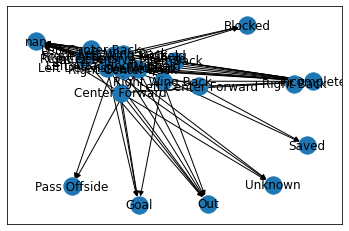

In [ ]:
nx.draw_networkx(match_graph_dict[3895333])

In [ ]:
events

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 3421, 'lineup': [{'player': {'id...",Bayer Leverkusen,904,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",Werder Bremen,176,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 3511, 'lineup': [{'player': {'id...",Union Berlin,190,00:00:00.000,Starting XI,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 3421, 'lineup': [{'player': {'id...",Bayer Leverkusen,904,00:00:00.000,Starting XI,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4222, 'lineup': [{'player': {'id...",Eintracht Frankfurt,184,00:00:00.000,Starting XI,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:08:42.397,Own Goal For,NaN
137761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bayer Leverkusen,904,00:17:34.031,Own Goal For,NaN
137762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Freiburg,183,00:14:53.261,Own Goal Against,NaN
137763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Werder Bremen,176,00:08:42.397,Own Goal Against,NaN
